## <center> Kaggle Project :
### <center> Paddy Doctor: Paddy Disease Classification
<center> Kaggle Team: AFES Paddy </center> 

---
Team Members: 
- Annine Duclaire Kenne
- Fenosoa Randrianjatovo	
-	Elysee Manimpire Gasana
-	Abiodun Saheed Ademola

---

In [5]:
# @title import all the neccessary packages
from __future__ import print_function 
from __future__ import division
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sb
import cv2
from torch.utils.data import Dataset, DataLoader
import io
import os
from PIL import Image
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install -q kaggle

In [8]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle

# copy the newly-uploaded file to that directory
! cp kaggle.json ~/.kaggle/

# # change permission of the file
! chmod 600 ~/.kaggle/kaggle.json


import os
# create new directory for the Kaggle project
!mkdir Paddy_Doctor

os.chdir('Paddy_Doctor')

Saving kaggle.json to kaggle.json


In [9]:
!kaggle competitions download -c paddy-disease-classification

 99% 1.01G/1.02G [00:36<00:00, 34.8MB/s]
100% 1.02G/1.02G [00:36<00:00, 30.1MB/s]


In [10]:
!unzip /content/Paddy_Doctor/paddy-disease-classification.zip > /dev/null

In [11]:
train_dir='/content/Paddy_Doctor/train_images'
test_dir='/content/Paddy_Doctor/test_images'

In [12]:
train_data_path = '/content/Paddy_Doctor/train.csv'
train_data = pd.read_csv(train_data_path)

train_data.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


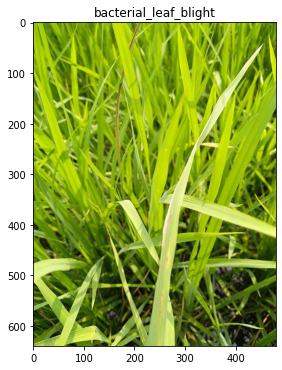

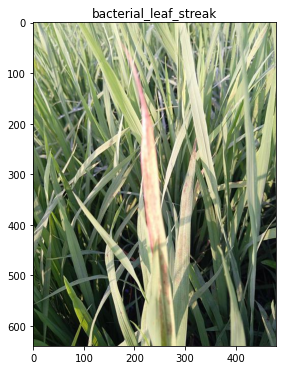

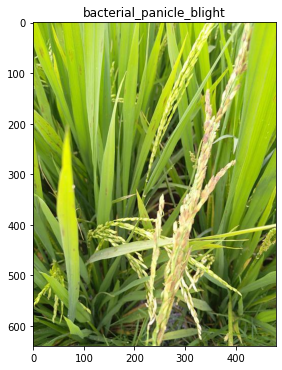

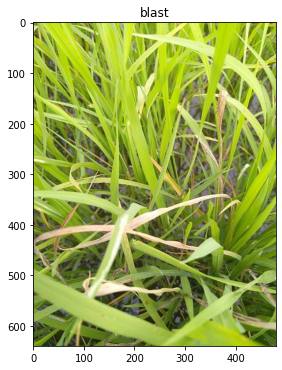

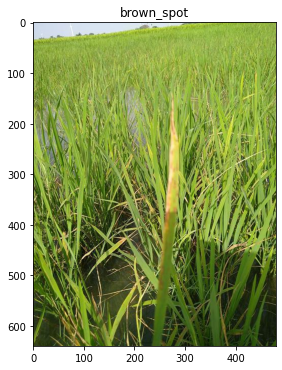

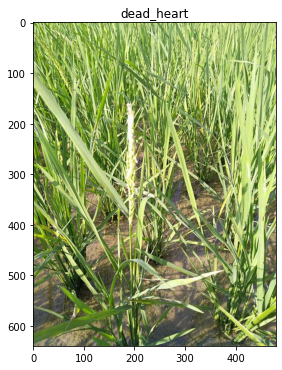

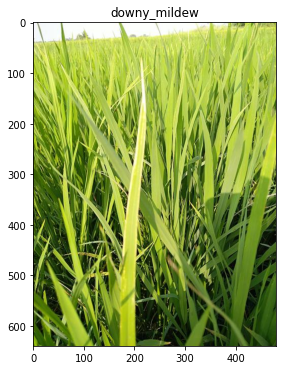

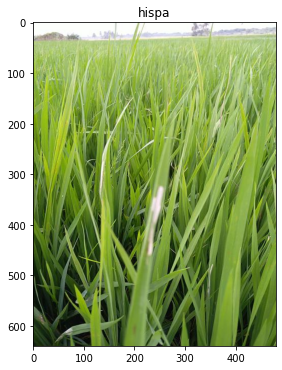

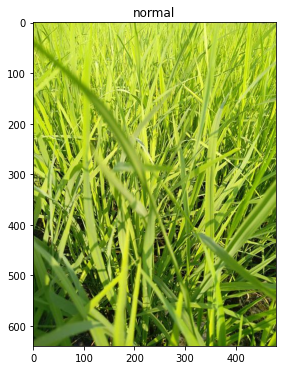

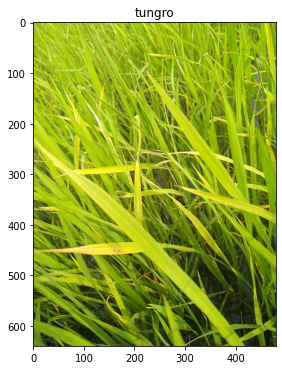

In [13]:
n_cols = 4
disease_groups = train_data.groupby("label")
row_count=1
for name,disease_group in disease_groups:
    index =0
    plot_index = 1
    plt.figure(figsize=(20,120))
    for row_index,row in disease_group.iterrows():
        img_path = os.path.join(train_dir,row.label, row.image_id)
        img = cv2.imread(img_path)
        plt.subplot(4,4,  plot_index)
        plot_index += 1
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"{row.label}")
        index += 1
        if index == 1:
            break
    row_count += 1
    plt.show()
        

In [14]:
labelArr = train_data['label'].unique()

label2id = {}
id2label = {}
index = 0
for  class_name in labelArr:
    label2id[class_name] = str(index)
    id2label[str(index)] = class_name
    index=index +1
print(label2id)

{'bacterial_leaf_blight': '0', 'bacterial_leaf_streak': '1', 'bacterial_panicle_blight': '2', 'blast': '3', 'brown_spot': '4', 'dead_heart': '5', 'downy_mildew': '6', 'hispa': '7', 'normal': '8', 'tungro': '9'}


In [15]:
res = models.resnet152

In [16]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet152"

# Number of classes in the dataset
num_classes = 10

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for 
num_epochs = 100

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

In [17]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train_data, test_size=0.05, random_state =0)
print(len(train))
print(len(valid))

9886
521


In [18]:
train['label'].value_counts()

normal                      1683
blast                       1651
hispa                       1498
dead_heart                  1370
tungro                      1036
brown_spot                   913
downy_mildew                 586
bacterial_leaf_blight        463
bacterial_leaf_streak        363
bacterial_panicle_blight     323
Name: label, dtype: int64

In [19]:
class PaddyDataset(Dataset):
    
    def __init__(self, dataframe, root_dir,is_train, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train 
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.dataframe.iloc[idx, 1],
                                self.dataframe.iloc[idx, 0])
        image1 = cv2.imread(img_name)
        image = Image.fromarray(image1)
        if self.is_train:
            labelKey = self.dataframe.iloc[idx, 1]
            label = torch.tensor(int(label2id[labelKey]))
            
        else:
            label =torch.tensor(1)

        if self.transform:
            image = self.transform(image)

        return image,label

In [20]:
input_size =224
transform_train = transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
transform_valid =      transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [21]:
train_dataset = PaddyDataset( train,root_dir='/content/Paddy_Doctor/train_images', is_train=True, transform=transform_train)
valid_dataset = PaddyDataset( valid,root_dir='/content/Paddy_Doctor/train_images', is_train=True, transform=transform_valid)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader =torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
dataloaders_dict ={}
dataloaders_dict['train']= train_loader
dataloaders_dict['val'] = val_loader

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)
  import sys


Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


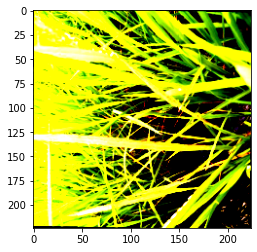

Label: 4


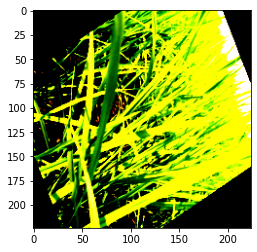

Label: 8


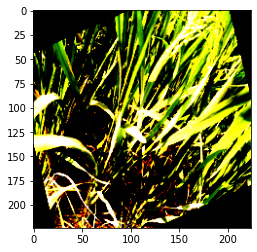

Label: 7


In [22]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
index =0
while index <3: 
    img = train_features[index].squeeze()
    img = (img.T).detach().numpy()
    label = train_labels[index]
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    print(f"Label: {label}")
    index = index +1 

In [ ]:
'''
def mean_std(loader):
  images, labels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std

mean, std = mean_std(dataloaders_dict['train'])
print("mean and std: \n", mean, std)
'''

In [23]:
from tqdm import tqdm

In [24]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs),total =num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #print(inputs)
                #print(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [25]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [27]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet152":
        """ Resnet34
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        
        model_ft.fc =  nn.Sequential(nn.Dropout(0.1),
                                     nn.Linear(num_ftrs, num_ftrs), nn.SiLU(),
                                     nn.Linear(num_ftrs,num_classes)
                                     )
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
      
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
    

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
# Send the model to GPU
torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
print(f'using {device} device')
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(params_to_update, lr=1e-3, momentum=0.9)
optimizer_ft = optim.Adam(params_to_update, lr=1e-3)

using cuda device
Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer2.2.conv1.weight
	 layer2.2.bn1.weight
	 layer2.2.bn1.bias
	 layer2.2.conv2.weight
	 layer2.2.bn2.weight
	 layer2.2.bn2.bias
	 layer2.3.conv1.weight
	 layer2.3.bn1.weig

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, 
                             dataloaders_dict, 
                             criterion, 
                             optimizer_ft,
                             num_epochs=num_epochs,
                             is_inception=(model_name=="inception"))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
----------
train Loss: 1.6753 Acc: 0.4094


  1%|          | 1/100 [01:55<3:10:24, 115.39s/it]

val Loss: 1.4637 Acc: 0.4914

Epoch 1/99
----------
train Loss: 1.3070 Acc: 0.5458


  2%|▏         | 2/100 [03:40<2:58:10, 109.09s/it]

val Loss: 1.4210 Acc: 0.5106

Epoch 2/99
----------
train Loss: 1.1008 Acc: 0.6231


  3%|▎         | 3/100 [05:23<2:52:06, 106.46s/it]

val Loss: 0.9903 Acc: 0.6641

Epoch 3/99
----------
train Loss: 0.9408 Acc: 0.6799


  4%|▍         | 4/100 [07:06<2:48:13, 105.14s/it]

val Loss: 0.8645 Acc: 0.7083

Epoch 4/99
----------
train Loss: 0.8215 Acc: 0.7223


  5%|▌         | 5/100 [08:53<2:47:18, 105.67s/it]

val Loss: 0.8171 Acc: 0.7179

Epoch 5/99
----------
train Loss: 0.7195 Acc: 0.7589


  6%|▌         | 6/100 [10:36<2:44:27, 104.97s/it]

val Loss: 0.8158 Acc: 0.7332

Epoch 6/99
----------
train Loss: 0.6469 Acc: 0.7804


  7%|▋         | 7/100 [12:21<2:42:42, 104.97s/it]

val Loss: 0.6248 Acc: 0.7908

Epoch 7/99
----------
train Loss: 0.5719 Acc: 0.8111


  8%|▊         | 8/100 [14:07<2:41:07, 105.08s/it]

val Loss: 0.7030 Acc: 0.7831

Epoch 8/99
----------
train Loss: 0.5095 Acc: 0.8283


  9%|▉         | 9/100 [15:50<2:38:42, 104.64s/it]

val Loss: 0.6537 Acc: 0.7774

Epoch 9/99
----------
train Loss: 0.4468 Acc: 0.8499


 10%|█         | 10/100 [17:34<2:36:31, 104.35s/it]

val Loss: 0.4088 Acc: 0.8656

Epoch 10/99
----------
train Loss: 0.4134 Acc: 0.8628


 11%|█         | 11/100 [19:18<2:34:47, 104.35s/it]

val Loss: 0.4086 Acc: 0.8618

Epoch 11/99
----------
train Loss: 0.3870 Acc: 0.8717


 12%|█▏        | 12/100 [21:02<2:32:50, 104.21s/it]

val Loss: 0.3468 Acc: 0.8829

Epoch 12/99
----------
train Loss: 0.3518 Acc: 0.8836


 13%|█▎        | 13/100 [22:45<2:30:41, 103.93s/it]

val Loss: 0.3978 Acc: 0.8599

Epoch 13/99
----------
train Loss: 0.3224 Acc: 0.8931


 14%|█▍        | 14/100 [24:31<2:29:30, 104.31s/it]

val Loss: 0.3698 Acc: 0.8791

Epoch 14/99
----------
train Loss: 0.3046 Acc: 0.8964


 15%|█▌        | 15/100 [26:13<2:27:08, 103.86s/it]

val Loss: 0.3419 Acc: 0.8829

Epoch 15/99
----------
train Loss: 0.2776 Acc: 0.9083


 16%|█▌        | 16/100 [27:56<2:24:53, 103.50s/it]

val Loss: 0.4341 Acc: 0.8484

Epoch 16/99
----------
train Loss: 0.2566 Acc: 0.9135


 17%|█▋        | 17/100 [29:39<2:22:58, 103.35s/it]

val Loss: 0.3329 Acc: 0.8752

Epoch 17/99
----------
train Loss: 0.2446 Acc: 0.9195


 18%|█▊        | 18/100 [31:23<2:21:22, 103.45s/it]

val Loss: 0.2197 Acc: 0.9213

Epoch 18/99
----------
train Loss: 0.2413 Acc: 0.9191


 19%|█▉        | 19/100 [33:04<2:18:42, 102.74s/it]

val Loss: 0.2685 Acc: 0.9098

Epoch 19/99
----------
train Loss: 0.2024 Acc: 0.9332


 20%|██        | 20/100 [34:45<2:16:26, 102.33s/it]

val Loss: 0.2037 Acc: 0.9328

Epoch 20/99
----------
train Loss: 0.2026 Acc: 0.9347


 21%|██        | 21/100 [36:28<2:14:58, 102.51s/it]

val Loss: 0.2874 Acc: 0.8964

Epoch 21/99
----------
train Loss: 0.1946 Acc: 0.9358


 22%|██▏       | 22/100 [38:10<2:12:52, 102.21s/it]

val Loss: 0.2042 Acc: 0.9386

Epoch 22/99
----------
train Loss: 0.1952 Acc: 0.9369


 23%|██▎       | 23/100 [39:51<2:10:48, 101.93s/it]

val Loss: 0.2104 Acc: 0.9290

Epoch 23/99
----------
train Loss: 0.1772 Acc: 0.9408


 24%|██▍       | 24/100 [41:32<2:08:45, 101.65s/it]

val Loss: 0.2477 Acc: 0.9251

Epoch 24/99
----------
train Loss: 0.1627 Acc: 0.9437


 25%|██▌       | 25/100 [43:15<2:07:39, 102.13s/it]

val Loss: 0.4405 Acc: 0.8848

Epoch 25/99
----------
train Loss: 0.1794 Acc: 0.9386


 26%|██▌       | 26/100 [44:56<2:05:38, 101.87s/it]

val Loss: 0.1911 Acc: 0.9424

Epoch 26/99
----------
train Loss: 0.1653 Acc: 0.9432


 27%|██▋       | 27/100 [46:39<2:04:07, 102.02s/it]

val Loss: 0.2476 Acc: 0.9251

Epoch 27/99
----------
train Loss: 0.1494 Acc: 0.9488


 28%|██▊       | 28/100 [48:21<2:02:39, 102.21s/it]

val Loss: 0.1468 Acc: 0.9463

Epoch 28/99
----------
train Loss: 0.1357 Acc: 0.9549


 29%|██▉       | 29/100 [50:05<2:01:18, 102.52s/it]

val Loss: 0.1903 Acc: 0.9424

Epoch 29/99
----------
train Loss: 0.1367 Acc: 0.9531


 30%|███       | 30/100 [51:46<1:59:18, 102.26s/it]

val Loss: 0.1483 Acc: 0.9539

Epoch 30/99
----------
train Loss: 0.1208 Acc: 0.9585


 31%|███       | 31/100 [53:28<1:57:21, 102.06s/it]

val Loss: 0.2367 Acc: 0.9309

Epoch 31/99
----------
train Loss: 0.1398 Acc: 0.9520


 32%|███▏      | 32/100 [55:11<1:55:59, 102.35s/it]

val Loss: 0.2276 Acc: 0.9405

Epoch 32/99
----------
train Loss: 0.1337 Acc: 0.9570


 33%|███▎      | 33/100 [56:52<1:53:46, 101.88s/it]

val Loss: 0.2174 Acc: 0.9482

Epoch 33/99
----------
train Loss: 0.1273 Acc: 0.9559


 34%|███▍      | 34/100 [58:34<1:52:05, 101.90s/it]

val Loss: 0.1776 Acc: 0.9520

Epoch 34/99
----------
train Loss: 0.1173 Acc: 0.9618


 35%|███▌      | 35/100 [1:00:15<1:50:08, 101.67s/it]

val Loss: 0.2077 Acc: 0.9463

Epoch 35/99
----------
train Loss: 0.1091 Acc: 0.9643


 36%|███▌      | 36/100 [1:01:58<1:48:50, 102.04s/it]

val Loss: 0.1756 Acc: 0.9405

Epoch 36/99
----------
train Loss: 0.1142 Acc: 0.9613


 37%|███▋      | 37/100 [1:03:40<1:47:05, 101.99s/it]

val Loss: 0.2115 Acc: 0.9501

Epoch 37/99
----------
train Loss: 0.1083 Acc: 0.9653


 38%|███▊      | 38/100 [1:05:22<1:45:23, 101.99s/it]

val Loss: 0.2689 Acc: 0.9309

Epoch 38/99
----------
train Loss: 0.1066 Acc: 0.9639


 39%|███▉      | 39/100 [1:07:03<1:43:34, 101.87s/it]

val Loss: 0.1856 Acc: 0.9443

Epoch 39/99
----------
train Loss: 0.1180 Acc: 0.9619


 40%|████      | 40/100 [1:08:47<1:42:34, 102.58s/it]

val Loss: 0.1608 Acc: 0.9616

Epoch 40/99
----------
train Loss: 0.0981 Acc: 0.9668


 41%|████      | 41/100 [1:10:30<1:40:50, 102.56s/it]

val Loss: 0.1882 Acc: 0.9463

Epoch 41/99
----------
train Loss: 0.1098 Acc: 0.9625


 42%|████▏     | 42/100 [1:12:12<1:38:56, 102.36s/it]

val Loss: 0.1836 Acc: 0.9443

Epoch 42/99
----------
train Loss: 0.0973 Acc: 0.9672


 43%|████▎     | 43/100 [1:13:55<1:37:34, 102.70s/it]

val Loss: 0.2182 Acc: 0.9501

Epoch 43/99
----------
train Loss: 0.0783 Acc: 0.9736


 44%|████▍     | 44/100 [1:15:37<1:35:30, 102.34s/it]

val Loss: 0.1339 Acc: 0.9578

Epoch 44/99
----------
train Loss: 0.0788 Acc: 0.9736


 45%|████▌     | 45/100 [1:17:19<1:33:52, 102.41s/it]

val Loss: 0.1962 Acc: 0.9501

Epoch 45/99
----------
train Loss: 0.1114 Acc: 0.9635


 46%|████▌     | 46/100 [1:19:03<1:32:22, 102.64s/it]

val Loss: 0.2488 Acc: 0.9443

Epoch 46/99
----------
train Loss: 0.0971 Acc: 0.9661


 47%|████▋     | 47/100 [1:20:48<1:31:25, 103.49s/it]

val Loss: 0.1941 Acc: 0.9501

Epoch 47/99
----------
train Loss: 0.0798 Acc: 0.9703


 48%|████▊     | 48/100 [1:22:31<1:29:27, 103.22s/it]

val Loss: 0.1913 Acc: 0.9501

Epoch 48/99
----------
train Loss: 0.0675 Acc: 0.9775


 49%|████▉     | 49/100 [1:24:13<1:27:34, 103.02s/it]

val Loss: 0.2294 Acc: 0.9463

Epoch 49/99
----------
train Loss: 0.0936 Acc: 0.9686


 50%|█████     | 50/100 [1:25:57<1:26:06, 103.34s/it]

val Loss: 0.1613 Acc: 0.9520

Epoch 50/99
----------
train Loss: 0.0934 Acc: 0.9690


 51%|█████     | 51/100 [1:27:40<1:24:19, 103.26s/it]

val Loss: 0.2529 Acc: 0.9232

Epoch 51/99
----------
train Loss: 0.0996 Acc: 0.9644


 52%|█████▏    | 52/100 [1:29:24<1:22:35, 103.24s/it]

val Loss: 0.1830 Acc: 0.9616

Epoch 52/99
----------
train Loss: 0.0724 Acc: 0.9759


 53%|█████▎    | 53/100 [1:31:06<1:20:45, 103.09s/it]

val Loss: 0.1688 Acc: 0.9616

Epoch 53/99
----------
train Loss: 0.0664 Acc: 0.9772


 54%|█████▍    | 54/100 [1:32:51<1:19:21, 103.52s/it]

val Loss: 0.1418 Acc: 0.9578

Epoch 54/99
----------
train Loss: 0.0676 Acc: 0.9773


 55%|█████▌    | 55/100 [1:34:35<1:17:44, 103.66s/it]

val Loss: 0.1138 Acc: 0.9674

Epoch 55/99
----------
train Loss: 0.0792 Acc: 0.9741


 56%|█████▌    | 56/100 [1:36:19<1:16:09, 103.86s/it]

val Loss: 0.1374 Acc: 0.9578

Epoch 56/99
----------
train Loss: 0.0677 Acc: 0.9770


 57%|█████▋    | 57/100 [1:38:04<1:14:42, 104.23s/it]

val Loss: 0.1488 Acc: 0.9597

Epoch 57/99
----------
train Loss: 0.0616 Acc: 0.9773


 58%|█████▊    | 58/100 [1:39:47<1:12:44, 103.93s/it]

val Loss: 0.1430 Acc: 0.9674

Epoch 58/99
----------
train Loss: 0.0825 Acc: 0.9703


 59%|█████▉    | 59/100 [1:41:31<1:10:53, 103.75s/it]

val Loss: 0.1373 Acc: 0.9616

Epoch 59/99
----------
train Loss: 0.0781 Acc: 0.9734


 60%|██████    | 60/100 [1:43:15<1:09:10, 103.77s/it]

val Loss: 0.1527 Acc: 0.9635

Epoch 60/99
----------
train Loss: 0.0641 Acc: 0.9770


 61%|██████    | 61/100 [1:45:00<1:07:48, 104.33s/it]

val Loss: 0.1886 Acc: 0.9559

Epoch 61/99
----------
train Loss: 0.0812 Acc: 0.9713


 62%|██████▏   | 62/100 [1:46:44<1:05:52, 104.01s/it]

val Loss: 0.2000 Acc: 0.9501

Epoch 62/99
----------
train Loss: 0.0824 Acc: 0.9725


 63%|██████▎   | 63/100 [1:48:27<1:04:04, 103.91s/it]

val Loss: 0.1962 Acc: 0.9443

Epoch 63/99
----------
train Loss: 0.0887 Acc: 0.9727


 64%|██████▍   | 64/100 [1:50:10<1:02:12, 103.69s/it]

val Loss: 0.2920 Acc: 0.9213

Epoch 64/99
----------
train Loss: 0.0697 Acc: 0.9758


 65%|██████▌   | 65/100 [1:51:55<1:00:41, 104.05s/it]

val Loss: 0.1600 Acc: 0.9655

Epoch 65/99
----------
train Loss: 0.0500 Acc: 0.9806


 66%|██████▌   | 66/100 [1:53:38<58:48, 103.77s/it]  

val Loss: 0.2183 Acc: 0.9443

Epoch 66/99
----------
train Loss: 0.0619 Acc: 0.9805


 67%|██████▋   | 67/100 [1:55:21<56:49, 103.31s/it]

val Loss: 0.1384 Acc: 0.9674

Epoch 67/99
----------
train Loss: 0.0632 Acc: 0.9777


 68%|██████▊   | 68/100 [1:57:03<54:59, 103.11s/it]

val Loss: 0.1607 Acc: 0.9616

Epoch 68/99
----------
train Loss: 0.0712 Acc: 0.9745


 69%|██████▉   | 69/100 [1:58:49<53:38, 103.81s/it]

val Loss: 0.1868 Acc: 0.9616

Epoch 69/99
----------
train Loss: 0.0534 Acc: 0.9832


 70%|███████   | 70/100 [2:00:30<51:32, 103.07s/it]

val Loss: 0.1202 Acc: 0.9693

Epoch 70/99
----------
train Loss: 0.0496 Acc: 0.9820


 71%|███████   | 71/100 [2:02:12<49:40, 102.78s/it]

val Loss: 0.1523 Acc: 0.9597

Epoch 71/99
----------
train Loss: 0.0524 Acc: 0.9813


 72%|███████▏  | 72/100 [2:03:54<47:53, 102.62s/it]

val Loss: 0.1308 Acc: 0.9635

Epoch 72/99
----------
train Loss: 0.0555 Acc: 0.9810


 73%|███████▎  | 73/100 [2:05:38<46:19, 102.94s/it]

val Loss: 0.1452 Acc: 0.9731

Epoch 73/99
----------
train Loss: 0.0522 Acc: 0.9827


 74%|███████▍  | 74/100 [2:07:20<44:32, 102.78s/it]

val Loss: 0.1125 Acc: 0.9712

Epoch 74/99
----------
train Loss: 0.0684 Acc: 0.9794


 75%|███████▌  | 75/100 [2:09:03<42:46, 102.65s/it]

val Loss: 0.1280 Acc: 0.9674

Epoch 75/99
----------
train Loss: 0.0530 Acc: 0.9808


 76%|███████▌  | 76/100 [2:10:45<40:58, 102.43s/it]

val Loss: 0.1787 Acc: 0.9616

Epoch 76/99
----------
train Loss: 0.0492 Acc: 0.9838


 77%|███████▋  | 77/100 [2:12:28<39:22, 102.70s/it]

val Loss: 0.1531 Acc: 0.9539

Epoch 77/99
----------
train Loss: 0.0649 Acc: 0.9779


 78%|███████▊  | 78/100 [2:14:10<37:35, 102.54s/it]

val Loss: 0.1587 Acc: 0.9616

Epoch 78/99
----------
train Loss: 0.0512 Acc: 0.9817


 79%|███████▉  | 79/100 [2:15:52<35:48, 102.29s/it]

val Loss: 0.1554 Acc: 0.9597

Epoch 79/99
----------
train Loss: 0.0572 Acc: 0.9821


 80%|████████  | 80/100 [2:17:33<34:00, 102.03s/it]

val Loss: 0.1763 Acc: 0.9539

Epoch 80/99
----------
train Loss: 0.0598 Acc: 0.9790


 81%|████████  | 81/100 [2:19:15<32:16, 101.90s/it]

val Loss: 0.2356 Acc: 0.9367

Epoch 81/99
----------
train Loss: 0.0498 Acc: 0.9815


 82%|████████▏ | 82/100 [2:20:58<30:42, 102.34s/it]

val Loss: 0.1410 Acc: 0.9635

Epoch 82/99
----------
train Loss: 0.0661 Acc: 0.9764


 83%|████████▎ | 83/100 [2:22:40<28:57, 102.23s/it]

val Loss: 0.1801 Acc: 0.9616

Epoch 83/99
----------
train Loss: 0.0447 Acc: 0.9838


 84%|████████▍ | 84/100 [2:24:22<27:13, 102.12s/it]

val Loss: 0.1693 Acc: 0.9693

Epoch 84/99
----------
train Loss: 0.0407 Acc: 0.9859


 85%|████████▌ | 85/100 [2:26:04<25:31, 102.10s/it]

val Loss: 0.2460 Acc: 0.9559

Epoch 85/99
----------
train Loss: 0.0561 Acc: 0.9827


 86%|████████▌ | 86/100 [2:27:47<23:50, 102.16s/it]

val Loss: 0.1971 Acc: 0.9539

Epoch 86/99
----------
train Loss: 0.0485 Acc: 0.9831


 87%|████████▋ | 87/100 [2:29:30<22:12, 102.47s/it]

val Loss: 0.2210 Acc: 0.9520

Epoch 87/99
----------
train Loss: 0.0385 Acc: 0.9874


 88%|████████▊ | 88/100 [2:31:12<20:27, 102.29s/it]

val Loss: 0.1869 Acc: 0.9693

Epoch 88/99
----------
train Loss: 0.0604 Acc: 0.9816


 89%|████████▉ | 89/100 [2:32:53<18:40, 101.89s/it]

val Loss: 0.1805 Acc: 0.9597

Epoch 89/99
----------
train Loss: 0.0467 Acc: 0.9838


 90%|█████████ | 90/100 [2:34:34<16:56, 101.66s/it]

val Loss: 0.1905 Acc: 0.9674

Epoch 90/99
----------
train Loss: 0.0434 Acc: 0.9856


 91%|█████████ | 91/100 [2:36:15<15:13, 101.45s/it]

val Loss: 0.1376 Acc: 0.9655

Epoch 91/99
----------
train Loss: 0.0407 Acc: 0.9855


 92%|█████████▏| 92/100 [2:37:58<13:35, 101.96s/it]

val Loss: 0.1388 Acc: 0.9693

Epoch 92/99
----------
train Loss: 0.0459 Acc: 0.9842


 93%|█████████▎| 93/100 [2:39:39<11:52, 101.79s/it]

val Loss: 0.2004 Acc: 0.9655

Epoch 93/99
----------
train Loss: 0.0587 Acc: 0.9810


 94%|█████████▍| 94/100 [2:41:21<10:10, 101.76s/it]

val Loss: 0.2461 Acc: 0.9520

Epoch 94/99
----------
train Loss: 0.1103 Acc: 0.9659


 95%|█████████▌| 95/100 [2:43:03<08:28, 101.78s/it]

val Loss: 0.1341 Acc: 0.9674

Epoch 95/99
----------
train Loss: 0.0541 Acc: 0.9834


 96%|█████████▌| 96/100 [2:44:46<06:48, 102.15s/it]

val Loss: 0.1737 Acc: 0.9597

Epoch 96/99
----------
train Loss: 0.0311 Acc: 0.9876


 97%|█████████▋| 97/100 [2:46:28<05:06, 102.10s/it]

val Loss: 0.1579 Acc: 0.9712

Epoch 97/99
----------
train Loss: 0.0381 Acc: 0.9867


 98%|█████████▊| 98/100 [2:48:11<03:25, 102.53s/it]

val Loss: 0.1404 Acc: 0.9616

Epoch 98/99
----------
train Loss: 0.0404 Acc: 0.9860


 99%|█████████▉| 99/100 [2:49:53<01:42, 102.25s/it]

val Loss: 0.1440 Acc: 0.9770

Epoch 99/99
----------
train Loss: 0.0310 Acc: 0.9896


100%|██████████| 100/100 [2:51:35<00:00, 102.95s/it]

val Loss: 0.1640 Acc: 0.9693

Training complete in 171m 35s
Best val Acc: 0.976967


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, 
                             dataloaders_dict, 
                             criterion, 
                             optimizer_ft,
                             num_epochs=num_epochs,
                             is_inception=(model_name=="inception"))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/14
----------
train Loss: 1.7358 Acc: 0.3888


  7%|▋         | 1/15 [01:44<24:20, 104.35s/it]

val Loss: 1.5081 Acc: 0.4453

Epoch 1/14
----------
train Loss: 1.3420 Acc: 0.5316


 13%|█▎        | 2/15 [03:27<22:27, 103.63s/it]

val Loss: 1.2720 Acc: 0.5509

Epoch 2/14
----------
train Loss: 1.1554 Acc: 0.6016


 20%|██        | 3/15 [05:11<20:47, 103.94s/it]

val Loss: 1.0700 Acc: 0.5969

Epoch 3/14
----------
train Loss: 0.9879 Acc: 0.6580


 27%|██▋       | 4/15 [06:54<18:59, 103.62s/it]

val Loss: 0.9564 Acc: 0.6814

Epoch 4/14
----------
train Loss: 0.8616 Acc: 0.7074


 33%|███▎      | 5/15 [08:39<17:18, 103.81s/it]

val Loss: 0.7707 Acc: 0.7255

Epoch 5/14
----------
train Loss: 0.7455 Acc: 0.7462


 40%|████      | 6/15 [10:27<15:48, 105.35s/it]

val Loss: 0.8403 Acc: 0.7159

Epoch 6/14
----------
train Loss: 0.6938 Acc: 0.7630


 47%|████▋     | 7/15 [12:11<13:59, 104.92s/it]

val Loss: 0.6925 Acc: 0.7562

Epoch 7/14
----------
train Loss: 0.6017 Acc: 0.7926


 53%|█████▎    | 8/15 [13:56<12:14, 104.94s/it]

val Loss: 0.6575 Acc: 0.7582

Epoch 8/14
----------
train Loss: 0.5604 Acc: 0.8123


 60%|██████    | 9/15 [15:40<10:28, 104.74s/it]

val Loss: 0.9382 Acc: 0.6929

Epoch 9/14
----------
train Loss: 0.4964 Acc: 0.8309


 67%|██████▋   | 10/15 [17:25<08:43, 104.74s/it]

val Loss: 0.4576 Acc: 0.8369

Epoch 10/14
----------
train Loss: 0.4511 Acc: 0.8487


 73%|███████▎  | 11/15 [19:08<06:57, 104.37s/it]

val Loss: 0.5261 Acc: 0.8177

Epoch 11/14
----------
train Loss: 0.4200 Acc: 0.8579


 80%|████████  | 12/15 [20:53<05:13, 104.56s/it]

val Loss: 0.3832 Acc: 0.8791

Epoch 12/14
----------
train Loss: 0.3830 Acc: 0.8716


 87%|████████▋ | 13/15 [22:37<03:28, 104.24s/it]

val Loss: 0.4026 Acc: 0.8541

Epoch 13/14
----------
train Loss: 0.3650 Acc: 0.8768


 93%|█████████▎| 14/15 [24:20<01:43, 103.98s/it]

val Loss: 0.5044 Acc: 0.8388

Epoch 14/14
----------
train Loss: 0.3273 Acc: 0.8934


100%|██████████| 15/15 [26:04<00:00, 104.33s/it]

val Loss: 0.3269 Acc: 0.8964

Training complete in 26m 5s
Best val Acc: 0.896353


```
    if model_name == "resnet152":
        """ Resnet34
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        
        model_ft.fc =  nn.Sequential(nn.Dropout(0.1),
                                     nn.Linear(num_ftrs, num_ftrs), nn.SiLU(),
                                     nn.Linear(num_ftrs,num_classes)
                                     )
        input_size = 224

```
---
```

 0%|          | 0/15 [00:00<?, ?it/s]Epoch 0/14
----------
train Loss: 1.7358 Acc: 0.3888
  7%|▋         | 1/15 [01:44<24:20, 104.35s/it]val Loss: 1.5081 Acc: 0.4453

Epoch 1/14
----------
train Loss: 1.3420 Acc: 0.5316
 13%|█▎        | 2/15 [03:27<22:27, 103.63s/it]val Loss: 1.2720 Acc: 0.5509


----------
train Loss: 0.4200 Acc: 0.8579
 80%|████████  | 12/15 [20:53<05:13, 104.56s/it]val Loss: 0.3832 Acc: 0.8791

Epoch 12/14
----------
train Loss: 0.3830 Acc: 0.8716
 87%|████████▋ | 13/15 [22:37<03:28, 104.24s/it]val Loss: 0.4026 Acc: 0.8541

Epoch 13/14
----------
train Loss: 0.3650 Acc: 0.8768
 93%|█████████▎| 14/15 [24:20<01:43, 103.98s/it]val Loss: 0.5044 Acc: 0.8388

Epoch 14/14
----------
train Loss: 0.3273 Acc: 0.8934
100%|██████████| 15/15 [26:04<00:00, 104.33s/it]val Loss: 0.3269 Acc: 0.8964

Training complete in 26m 5s
Best val Acc: 0.896353

```

---

- The accuracy is ***0.89273*** on the leaderboard


---

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, 
                             dataloaders_dict, 
                             criterion, 
                             optimizer_ft,
                             num_epochs=num_epochs,
                             is_inception=(model_name=="inception"))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/14
----------
train Loss: 1.7016 Acc: 0.4009


  7%|▋         | 1/15 [01:44<24:27, 104.85s/it]

val Loss: 1.5110 Acc: 0.4798

Epoch 1/14
----------
train Loss: 1.4716 Acc: 0.4741


 13%|█▎        | 2/15 [03:29<22:43, 104.92s/it]

val Loss: 1.3490 Acc: 0.5336

Epoch 2/14
----------
train Loss: 1.3049 Acc: 0.5458


 20%|██        | 3/15 [05:15<21:02, 105.19s/it]

val Loss: 1.0792 Acc: 0.6238

Epoch 3/14
----------
train Loss: 1.1881 Acc: 0.5851


 27%|██▋       | 4/15 [06:58<19:07, 104.28s/it]

val Loss: 1.0043 Acc: 0.6699

Epoch 4/14
----------
train Loss: 1.1280 Acc: 0.6118


 33%|███▎      | 5/15 [08:41<17:19, 103.99s/it]

val Loss: 1.3475 Acc: 0.5893

Epoch 5/14
----------
train Loss: 0.9919 Acc: 0.6572


 40%|████      | 6/15 [10:24<15:30, 103.43s/it]

val Loss: 1.1157 Acc: 0.6372

Epoch 6/14
----------
train Loss: 0.9083 Acc: 0.6843


 47%|████▋     | 7/15 [12:07<13:48, 103.52s/it]

val Loss: 1.0583 Acc: 0.6353

Epoch 7/14
----------
train Loss: 0.8312 Acc: 0.7175


 53%|█████▎    | 8/15 [13:50<12:03, 103.42s/it]

val Loss: 0.8925 Acc: 0.6987

Epoch 8/14
----------
train Loss: 0.7490 Acc: 0.7489


 60%|██████    | 9/15 [15:35<10:21, 103.64s/it]

val Loss: 0.7031 Acc: 0.7428

Epoch 9/14
----------
train Loss: 0.6645 Acc: 0.7749


 67%|██████▋   | 10/15 [17:17<08:36, 103.38s/it]

val Loss: 0.6485 Acc: 0.8042

Epoch 10/14
----------
train Loss: 0.6236 Acc: 0.7931


 73%|███████▎  | 11/15 [19:01<06:53, 103.32s/it]

val Loss: 0.6503 Acc: 0.7793

Epoch 11/14
----------
train Loss: 0.5603 Acc: 0.8122


 80%|████████  | 12/15 [20:45<05:10, 103.55s/it]

val Loss: 0.5718 Acc: 0.8177

Epoch 12/14
----------
train Loss: 0.5227 Acc: 0.8281


 87%|████████▋ | 13/15 [22:30<03:28, 104.01s/it]

val Loss: 0.6800 Acc: 0.7908

Epoch 13/14
----------
train Loss: 0.5109 Acc: 0.8277


 93%|█████████▎| 14/15 [24:20<01:45, 105.89s/it]

val Loss: 0.9592 Acc: 0.7850

Epoch 14/14
----------
train Loss: 0.4642 Acc: 0.8452


100%|██████████| 15/15 [26:04<00:00, 104.30s/it]

val Loss: 0.4084 Acc: 0.8464

Training complete in 26m 5s
Best val Acc: 0.846449


```

  0%|          | 0/15 [00:00<?, ?it/s]Epoch 0/14
----------
train Loss: 1.7016 Acc: 0.4009
  7%|▋         | 1/15 [01:44<24:27, 104.85s/it]val Loss: 1.5110 Acc: 0.4798

Epoch 1/14
----------
train Loss: 1.4716 Acc: 0.4741
 13%|█▎        | 2/15 [03:29<22:43, 104.92s/it]val Loss: 1.3490 Acc: 0.5336
....


----------
train Loss: 0.5109 Acc: 0.8277
 93%|█████████▎| 14/15 [24:20<01:45, 105.89s/it]val Loss: 0.9592 Acc: 0.7850

Epoch 14/14
----------
train Loss: 0.4642 Acc: 0.8452
100%|██████████| 15/15 [26:04<00:00, 104.30s/it]val Loss: 0.4084 Acc: 0.8464

Training complete in 26m 5s
Best val Acc: 0.846449



TEST Score on the leaderboard : Score: 0.85313



```

In [ ]:
folder = './test_images'
if not os.path.exists(folder):
        os.makedirs(folder)
        
test_dataframe = pd.DataFrame(enumerate(sorted(os.listdir(test_dir))))

test_dataframe.head()

In [ ]:
class PaddyTestDataset(Dataset):
    
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.dataframe.iloc[idx, 1])
        image1 = cv2.imread(img_name)
        image = Image.fromarray(image1)
        
        label =torch.tensor(1)

        if self.transform:
            image = self.transform(image)

        return image,self.dataframe.iloc[idx, 1]


In [ ]:
test_dataset = PaddyTestDataset( test_dataframe,root_dir='/content/Paddy_Doctor/test_images', transform=transform_valid)

In [ ]:
test_loader =torch.utils.data.DataLoader(test_dataset, batch_size=16, num_workers=2)

In [ ]:
#model_ft.cuda()
model_ft.eval()
filenames=[]
finalpredictions=[]
for inputs, files in test_loader:
                #print(inputs)
                #print(files)
                inputs = inputs.to(device)
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs, 1)
                finalpred=[]
                for file in files:
                    filenames.append(file)
                for pred in preds:
                    finalpredictions.append(id2label[str(pred.item())])
                #print(finalpred)
                

In [ ]:
df_preds = pd.DataFrame({'image_id': filenames, "label": finalpredictions})
df_preds.head()

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


In [ ]:
test_df = pd.read_csv("/content/Paddy_Doctor/sample_submission.csv")

submission_df = pd.merge(test_df[['image_id']], df_preds, how='inner', on='image_id')

submission_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Paddy_Doctor/submission_resnet152_with_fc.csv", index = False)

submission_df.head()


,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


In [ ]:
print(len(submission_df))

3469


# Done